## EPI blip-up blip-down correction
###### Author: Zimu Huo
###### Date: 07.2022



Let's consider a simplified scenario where the b0 varies only in one direction and the distortion occurs along this dimension as well. In this case, the distortion can be thought of as stretching or dilating the image. The line integral approach leverages this property by assuming that the total line integral along the distortion direction should be identical. Since we know that the distortion is equal and opposite, we can derive the displacement field and the corrected image.

-------------------------------------------------------------------------
References

    [1] 
    Author: Huairen Zeng, R Todd Constable
    Title:  Image distortion correction in EPI: comparison of field mapping with point spread function mapping
    Link: https://pubmed.ncbi.nlm.nih.gov/12111941/

In [4]:
import sys
sys.path.insert(1, '../')
sys.path.insert(1, '../../')
import numpy as np
import matplotlib.pyplot as plt
from util.fft import * 
from util.phantom import * 
from util.coil import * 
from util.tool import * 

In [5]:
import scipy.io
def get_tissue_images(): # helper function to create realistic phantom
    tissuetype = ['graymatter', 'deep_graymatter', 'whitematter', 'csf']
    T2 = [110, 100, 60, 1500]
    T2s = [40, 45, 50, 1000]
    mat = scipy.io.loadmat('../lib/tissue_images.mat')
    tissues = mat.get("tissue_images")[:,:,:,:]
    return np.squeeze(tissues), tissuetype


In [6]:
def gaussian_noise(shape, L = None, mu = 0, sigma = 1):
    [ny, nx] = shape
    n = np.zeros([ny * nx], dtype = complex)
    n.real = np.random.normal(mu, sigma, ny*nx).reshape(ny * nx)
    n.imag = np.random.normal(mu, sigma, ny*nx).reshape(ny * nx)
    return n.reshape(ny, nx)

In [7]:
tissues,tissuetype = get_tissue_images()
ny, nx, nz, nt = tissues.shape

In [8]:
TE = 100
ideal_image = np.zeros([ny, nx, nz], dtype = complex)
for t in range(nt):
    ideal_image += tissues[...,t] * np.exp(TE/t2(tissuetype[t]))
ideal_image = ideal_image[:,:,nz//2]

<div style="font-size: 1.2em;">
Next we generate a off-resonance field in the frequency encoding direction, the slow direction of EPI acquistion. 
</div>


In [9]:
G = 0.005
fov = ny
dwell_time = 1
gamma = 2* np.pi * 42.58
t = np.linspace(-1, 1, nx) * 1E-3 * fov
phase_inc = gamma * G * dwell_time
field = np.zeros([ny, nx], dtype = complex)
for y in range(ny):
    field[y] =  phase_inc * y 

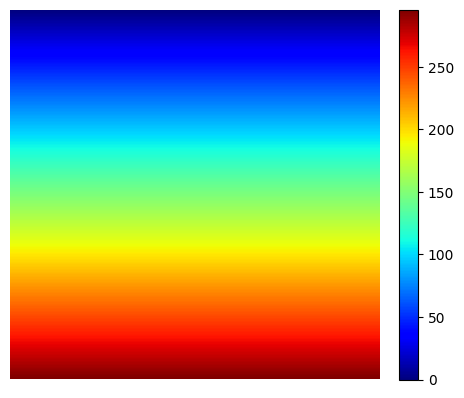

In [10]:
showc(field)

<div style="font-size: 1.2em;">
Now, we simulate the image acquisition process by tracing two paths: one starting from the top of the image to the bottom, and another from the bottom to the top. 
    
This allows us to investigate how the distortion affects the image formation -> should be equal and opposite
</div>


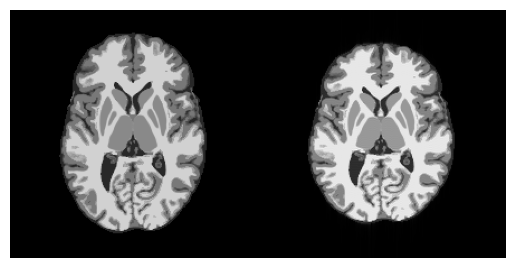

In [15]:
image = np.zeros([ny, nx], dtype = complex)
G = 0.01
fov = ny
dwell_time = 1
gamma = 2* np.pi * 42.58
t = np.linspace(-1, 1, nx) * 1E-3 * fov
phase_inc = gamma * G * dwell_time
for y in range(ny):
    modulation = np.exp(1j * t * field[y])
    modulation = np.repeat(modulation[:,None], nx, -1)
    tmp = ideal_image * modulation 
    image[y] = fft2c(tmp)[y]
contracted = ifft2c(image)
show(np.concatenate((ideal_image, contracted), -1) )

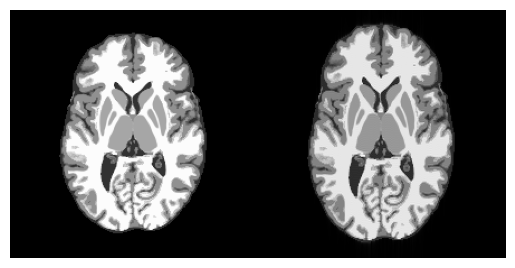

In [16]:
image = np.zeros([ny, nx], dtype = complex)
G = 0.01
fov = ny
dwell_time = 1
gamma = 2* np.pi * 42.58
t = np.linspace(-1, 1, nx) * 1E-3 * fov
phase_inc = gamma * G * dwell_time
for y in range(ny-1,0,-1):
    modulation = np.exp(1j * t * field[ny-y])
    modulation = np.repeat(modulation[:,None], nx, -1)
    tmp = ideal_image * modulation 
    image[y] = fft2c(tmp)[y]
extended = ifft2c(image)
show(np.concatenate((ideal_image, extended), -1) )

In [21]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

In [24]:
from tqdm import tqdm
from scipy import interpolate
def blip_reversed_correction_line_integral(contracted, extended, oversampling = 50, overgrid = 10):
    # perform line inetgral distortion correction, for each column of the image (vertical direction)
    # Author: Zimu Huo 
    [ny,nx] = contracted.shape
    recon = np.zeros([ny, nx])
    for x in tqdm(range(nx)):
        sig1 = np.cumsum(np.abs(contracted[:,x]))
        sig2 = np.cumsum(np.abs(extended[:,x]))
        avg = (sig1+sig2)/2
        maxval = (max(sig1)+ max(sig2))/2
        minval = (min(sig1)+min(sig2)) / 2
        f1 =  interpolate.interp1d(np.linspace(0,1,ny), sig1, kind='cubic', bounds_error=False, fill_value=0)
        f2 =  interpolate.interp1d(np.linspace(0,1,ny), sig2, kind='cubic', bounds_error=False, fill_value=0)
        y1s = f1(np.linspace(0, 1, ny*overgrid))
        y2s = f2(np.linspace(0, 1, ny*overgrid))
        list_idx = []
        list_val = []
        for val in (np.linspace(minval, maxval, ny * oversampling)):
            x1 = find_nearest(y1s, val) / overgrid
            x2 = find_nearest(y2s, val) / overgrid
            if (x1+x2)/2 not in list_idx:
                list_idx.append((x1+x2)/2)
                list_val.append(val)
        list_idx.append(ny)
        list_val.append(maxval)
        idx = np.asarray(list_idx)
        val = np.asarray(list_val)
        f = interpolate.interp1d(idx, val, kind='linear', bounds_error=False, fill_value=0)
        b = f(np.arange(ny))
        b[b>maxval] = 0
        for i in range(1,b.size):
            if b[i] < b[i-1]:
                b[i] = b[i-1]
        recon[:,x] = np.ediff1d(b, to_begin=b[0])
    return recon 

In [25]:
from tqdm import tqdm
from scipy import interpolate
def blip_reversed_correction_displacement_field(contracted, extended, oversampling = 10, overgrid = 10):
    [ny,nx] = contracted.shape
    recon = np.zeros([ny, nx])
    for x in tqdm(range(nx)):
        sig1 = np.cumsum(np.abs(contracted[:,x]))
        sig2 = np.cumsum(np.abs(extended[:,x]))
        avg = (sig1+sig2)/2
        maxval = (max(sig1)+ max(sig2))/2
        minval = (min(sig1)+min(sig2)) / 2
        f1 =  interpolate.interp1d(np.linspace(0,1,ny), sig1, kind='cubic', bounds_error=False, fill_value=0)
        f2 =  interpolate.interp1d(np.linspace(0,1,ny), sig2, kind='cubic', bounds_error=False, fill_value=0)
        y1s = f1(np.linspace(0, 1, ny*overgrid))
        y2s = f2(np.linspace(0, 1, ny*overgrid))
        list_idx = []
        list_val = []
        for val in (np.linspace(minval, maxval, ny * oversampling)):
            x1 = find_nearest(y1s, val) / overgrid
            x2 = find_nearest(y2s, val) / overgrid
            if (x1+x2)/2 not in list_idx:
                list_idx.append((x1+x2)/2)
                list_val.append((x1-x2))
        list_idx.append(ny)
        list_val.append(maxval)
        idx = np.asarray(list_idx)
        val = np.asarray(list_val)
        f = interpolate.interp1d(idx[:-5], val[:-5], kind='linear', bounds_error=False, fill_value=0)
        b = f(np.arange(ny))
        recon[:,x] = b
    return recon 

In [26]:
recon = blip_reversed_correction_line_integral(contracted, extended)

100%|████████████████████████████████████████████████████████████████████████████████| 222/222 [00:52<00:00,  4.20it/s]


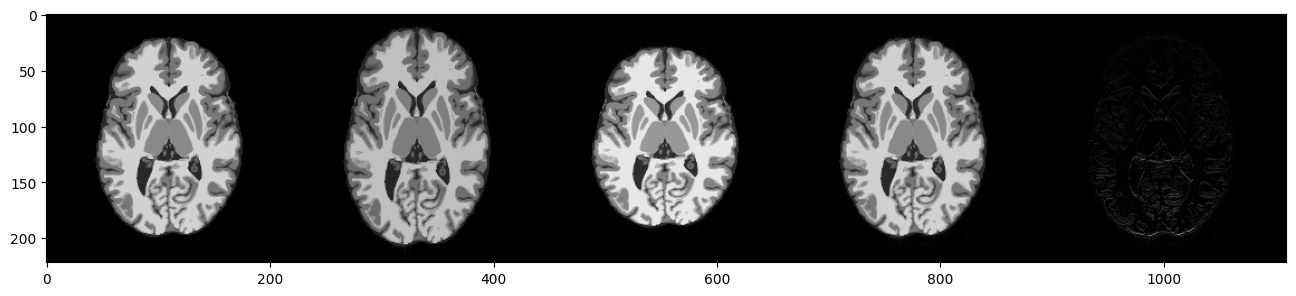

In [27]:
plt.figure(figsize = (16,12))
plt.imshow(np.abs(np.concatenate((ideal_image, extended, contracted, recon, ideal_image-recon), -1)), cmap = "gray" )
plt.show()

In [28]:
displacementfield = blip_reversed_correction_displacement_field(contracted, extended)

100%|████████████████████████████████████████████████████████████████████████████████| 222/222 [00:07<00:00, 28.69it/s]


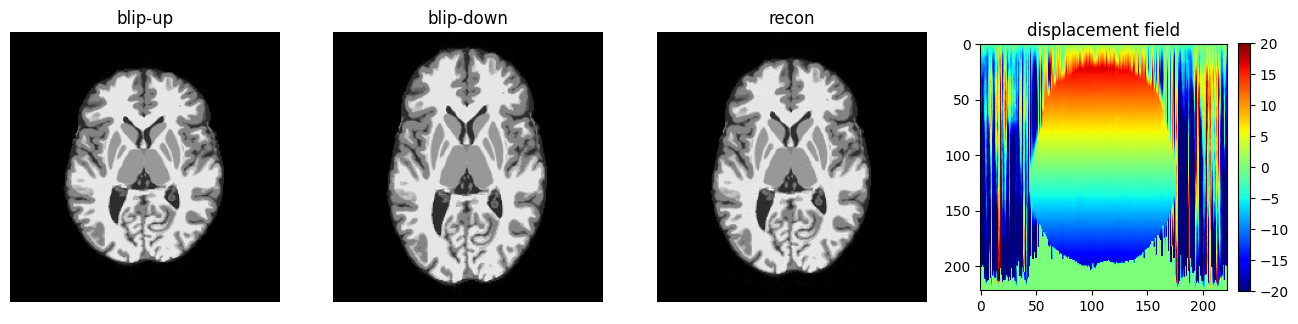

In [29]:
plt.figure(figsize = (16,12))
plt.subplot(141)
plt.title("blip-up")
plt.imshow(np.abs(contracted), cmap = "gray")
plt.axis('off')
plt.subplot(142)
plt.title("blip-down")
plt.imshow(np.abs(extended), cmap = "gray")
plt.axis('off')
plt.subplot(143)
plt.title("recon")
plt.imshow(np.abs(recon), cmap = "gray")
plt.axis('off')
plt.subplot(144)
plt.title("displacement field")
tf = plt.imshow(displacementfield,cmap='jet')
plt.colorbar(tf, fraction=0.046, pad=0.04)
plt.clim([-20,20])
plt.savefig("blipupdown_lineintegral")
plt.show()